### 1. Import libraries

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
from statsmodels.stats.diagnostic import linear_rainbow
import statsmodels.api as sm
from scipy.special import expit, logit
from scipy.stats import norm
import scipy.stats as stats

### 2. Load data set

In [12]:
df = pd.read_json('/mnt/d/PYDataScience/HIV_TXP_SR/data/supp.json')
# Print the shape of the DataFrame
print(f"Number of rows: {df.shape[0]}")
print(f"Number of columns: {df.shape[1]}")

# Print the column names
print(df.columns)

Number of rows: 48
Number of columns: 146
Index(['study_id', 'author', 'year_of_publication', 'country_of_study',
       'study_type', 'sample_size_(hiv_seropositive_only)', 'intervention',
       'outcome', 'conclusion', 'hiv_negative_samples',
       ...
       'cochrane_rob_missing_outcome_data_is_it_likely_that_missingness_in_the_outcome_depended_on_its_true_value?',
       'cochrane_rob_risk_of_bias_in_measurement_of_the_outcome_was_the_method_of_measuring_the_outcome_inappropriate?',
       'cochrane_rob_risk_of_bias_in_measurement_of_the_outcome_could_measurement_or_ascertainment_of_the_outcome_have_differed_between_intervention_groups?',
       'cochrane_rob_risk_of_bias_in_measurement_of_the_outcome_were_outcome_assessors_aware_of_the_intervention_received_by_study_participants?',
       'cochrane_rob_risk_of_bias_in_measurement_of_the_outcome_could_assessment_of_the_outcome_have_been_influenced_by_knowledge_of_intervention_received?',
       'cochrane_rob_risk_of_bias_in_meas

### 3. Publication bias with funnel plot, Egger's test and Begg's Rank correlation test

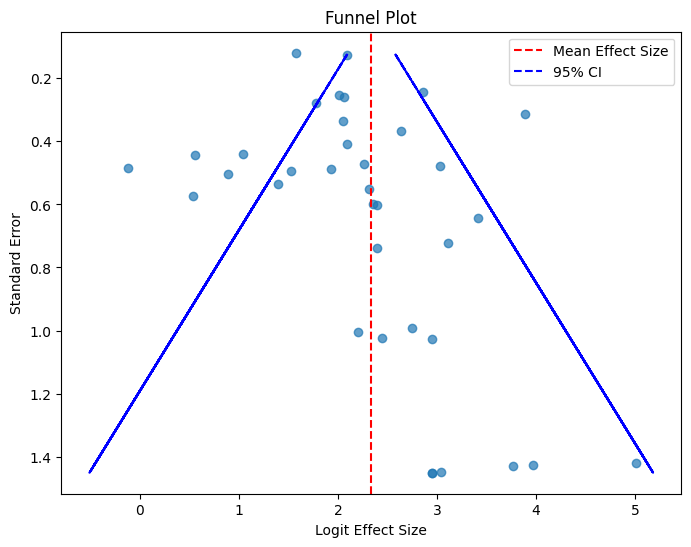

Egger's Regression Test Results:
{'slope': 1.3678245087387324, 'intercept': 1.4186256379630509, 'r_value': 0.546830896992919, 'p_value': 0.0005587808962861658, 'std_err': 0.35916122384955573}
Begg's Rank Correlation Test Results:
{'slope': 1.2590939773531762, 'intercept': 14.558718291284496, 'r_value': 0.12426417776729533, 'p_value': 0.4702464706146271, 'std_err': 1.7242231887847552}


In [26]:
# Creating a copy of the relevant columns
survival_data = df[["study_id", "1-year_patient_survival_(%)_hiv+", "3-year_patient_survival_(%)_hiv+", ">=_5-year_patient_survival_(%)_hiv+"]].copy()

# Replacing "None" with NaN and ensuring the data is numeric
survival_data.replace("None", np.nan, inplace=True)
survival_data.iloc[:, 1:] = survival_data.iloc[:, 1:].apply(pd.to_numeric, errors='coerce')

# Initialize an empty list for effect sizes
effect_size = np.full(len(survival_data), np.nan)

# Apply selection criteria
for i in range(len(survival_data)):
    if not pd.isna(survival_data.iloc[i, 3]):
        effect_size[i] = survival_data.iloc[i, 3]
    elif not pd.isna(survival_data.iloc[i, 2]):
        effect_size[i] = survival_data.iloc[i, 2]
    elif not pd.isna(survival_data.iloc[i, 1]):
        effect_size[i] = survival_data.iloc[i, 1]

effect_size = effect_size / 100
sample_size = df['sample_size_(hiv_seropositive_only)'].to_numpy()

# Adjust effect sizes slightly to avoid 0% and 100%
effect_size = np.clip(effect_size, 1 / (2 * sample_size), 1 - 1 / (2 * sample_size))

# Apply logit transformation
logit_effect_size = np.log(effect_size / (1 - effect_size))

# Calculate standard error after logit transformation
se_logit = np.sqrt(1 / (sample_size * effect_size) + 1 / (sample_size * (1 - effect_size)))

# Remove NaN values from both logit_effect_size and se_logit
mask = ~np.isnan(logit_effect_size) & ~np.isnan(se_logit)
logit_effect_size_filtered = logit_effect_size[mask]
se_logit_filtered = se_logit[mask]

# Funnel plot
# Calculating the overall mean effect size
mean_effect_size = np.mean(logit_effect_size_filtered)

# Create the funnel plot
plt.figure(figsize=(8, 6))
plt.scatter(logit_effect_size_filtered, se_logit_filtered, alpha=0.7)

# Adding the vertical line for the mean effect size
plt.axvline(mean_effect_size, color='red', linestyle='--', label='Mean Effect Size')

# Adding the diagonal lines representing 95% CI
upper_ci = mean_effect_size + 1.96 * se_logit_filtered
lower_ci = mean_effect_size - 1.96 * se_logit_filtered
plt.plot(mean_effect_size + se_logit_filtered * 1.96, se_logit_filtered, color='blue', linestyle='--', label='95% CI')
plt.plot(mean_effect_size - se_logit_filtered * 1.96, se_logit_filtered, color='blue', linestyle='--')

# Inverting the y-axis
plt.gca().invert_yaxis()

# Labels and title
plt.xlabel('Logit Effect Size')
plt.ylabel('Standard Error')
plt.title('Funnel Plot')
plt.legend()

# Show the plot
plt.show()

# Egger's Regression Test (using linregress)
slope, intercept, r_value, p_value, std_err = linregress(se_logit_filtered, logit_effect_size_filtered)
egger_test = {
    "slope": slope,
    "intercept": intercept,
    "r_value": r_value,
    "p_value": p_value,
    "std_err": std_err
}
print("Egger's Regression Test Results:")
print(egger_test)

# Begg's Rank Correlation Test (approximation using Spearman correlation)
begg_slope, begg_intercept, begg_r_value, begg_p_value, begg_std_err = linregress(logit_effect_size_filtered, np.arange(len(logit_effect_size_filtered)))
begg_test = {
    "slope": begg_slope,
    "intercept": begg_intercept,
    "r_value": begg_r_value,
    "p_value": begg_p_value,
    "std_err": begg_std_err
}
print("Begg's Rank Correlation Test Results:")
print(begg_test)

### 4. Meta-analysis of primary outcome

In [39]:
# Select and rename columns
pt_survival_df = df[['sample_size_(hiv_seropositive_only)', 'study_id', 
                     '1-year_patient_survival_(%)_hiv+', 
                     '3-year_patient_survival_(%)_hiv+', 
                     '>=_5-year_patient_survival_(%)_hiv+']].copy()
pt_survival_df.columns = ['sample_size', 'study_id', '1_yr', '3_yr', '5_yr']

# Function to convert logit to proportion
def logit_to_proportion(logit_value):
    return expit(logit_value)  # expit is the inverse of logit

# Function to perform meta-analysis and plot with matplotlib
def perform_meta_analysis(valid_data):
    # Avoid proportions of 0 and 1 by adding a small constant
    epsilon = 0.5 / np.min(valid_data['sample_size'])
    valid_data['proportion'] = np.clip(valid_data['proportion'], epsilon, 1 - epsilon)
    # Logit transformation of proportions
    valid_data['z'] = logit(valid_data['proportion'])
    
    # Variance of logit-transformed proportions
    valid_data['var_z'] = 1 / (np.array(valid_data['sample_size']) * valid_data['proportion'] * (1 - valid_data['proportion']))
    
    w = 1 / np.array(valid_data['var_z'])
    z_bar = np.sum(w * valid_data['z']) / np.sum(w)
    k = len(valid_data['z'])  
    Q = np.sum(w * (valid_data['z'] - z_bar)**2)
    
    # Calculating p-value for Q
    p_value_Q = 1 - stats.chi2.cdf(Q, k - 1)

    if Q == k - 1:
        I2 = 0
    else:
        I2 = max(0, ((Q - (k - 1)) / Q) * 100)

    denominator = (np.sum(w) - (np.sum(w**2) / np.sum(w)))
    tau2 = 0 if denominator == 0 else (Q - (k - 1)) / denominator
    tau2 = max(0, tau2)  # Ensure non-negativity
    w_RE = 1 / (np.array(valid_data['var_z']) + tau2)
    w_RE_sum = np.sum(w_RE)
    if w_RE_sum == 0:
        z_bar_RE = 0
        weights_percent = [0] * k
    else:
        z_bar_RE = np.sum(w_RE * valid_data['z']) / w_RE_sum
        weights_percent = (w_RE / w_RE_sum) * 100

    se_z_bar_RE = np.sqrt(1 / np.sum(w_RE)) if w_RE_sum != 0 else 0
    ci_z_bar_RE = (z_bar_RE - 1.96*se_z_bar_RE, z_bar_RE + 1.96*se_z_bar_RE)

    # Back Transformation to proportion scale
    proportion_bar_RE = expit(z_bar_RE)
    ci_proportion_bar_RE = (expit(ci_z_bar_RE[0]), expit(ci_z_bar_RE[1]))

    # Prepare DataFrame with study-specific results
    valid_data['effect_size'] = expit(valid_data['z'])
    valid_data['ci_lb'] = expit(valid_data['z'] - 1.96 * np.sqrt(valid_data['var_z']))
    valid_data['ci_ub'] = expit(valid_data['z'] + 1.96 * np.sqrt(valid_data['var_z']))
    valid_data['weight_percent'] = weights_percent

    # Create a DataFrame for the pooled result
    pooled_result = pd.DataFrame({
        'study_id': ['Pooled Estimate'],
        'sample_size': [np.sum(valid_data['sample_size'])],
        'effect_size': [proportion_bar_RE],
        'ci_lb': [ci_proportion_bar_RE[0]],
        'ci_ub': [ci_proportion_bar_RE[1]],
        'weight_percent': [np.sum(weights_percent)]
    })

    # Combine individual study results with the pooled result
    combined_results = pd.concat([valid_data[['study_id', 'sample_size', 'effect_size', 'ci_lb', 'ci_ub', 'weight_percent']], pooled_result])

    return proportion_bar_RE, ci_proportion_bar_RE, combined_results, I2, Q, p_value_Q, tau2

# Prepare data for 1-year survival meta-analysis
pt_survival_df['proportion'] = pt_survival_df['1_yr'] / 100
valid_data = pt_survival_df[['study_id', 'sample_size', 'proportion']].dropna()

# Perform the meta-analysis
proportion_bar_RE, ci_proportion_bar_RE, combined_results, I2, Q, p_value_Q, tau2 = perform_meta_analysis(valid_data)

# Display the results
print(f"Pooled 1-Year Survival Proportion: {proportion_bar_RE:.4f}")
print(f"95% CI: ({ci_proportion_bar_RE[0]:.4f}, {ci_proportion_bar_RE[1]:.4f})")
print(f"I²: {I2:.2f}%")
print(f"Q: {Q:.2f}")
print(f"p-value for Q: {p_value_Q:.4f}")
print(f"tau2: {tau2:.4f}")
# Display the combined results for each study and the pooled result
print(combined_results)



Pooled 1-Year Survival Proportion: 0.9399
95% CI: (0.9283, 0.9497)
I²: 0.00%
Q: 12.55
p-value for Q: 0.9611
tau2: 0.0000
           study_id  sample_size  effect_size     ci_lb     ci_ub  \
2        Alfano2018           19      0.94400  0.704556  0.991678   
5          Azar2017           13      0.95000  0.610687  0.995674   
8       Camargo2019           22      0.95000  0.736354  0.992323   
9      Camargo2019a           13      0.92000  0.607923  0.988412   
11       Durand2021           75      0.95000  0.870570  0.981709   
15      Gathogo2014           35      0.91300  0.764105  0.971428   
16      Gathogo2016           78      0.95000  0.872825  0.981343   
17      Gathogo2017           40      0.95000  0.820907  0.987462   
20        Locke2009          100      0.95000  0.885455  0.979036   
21        Locke2014          516      0.95000  0.927475  0.965787   
22        Locke2015          499      0.94560  0.921911  0.962396   
25        Malat2018          120      0.95000  0.89